# ***Case Study Data Mining (Klasifikasi)***
## *Kelompok 3*

### Anggota Kelompok:
- Favian Sulthan Wafi - 2106706205
- Fernaldy - 2106706464
- Kalisha Rahma Firza - 2106725053
- Nasywa Safira Ardanty - 2106704074
- Nurkhalisha Humaira - 2106703802

#Import Package dan Data#

In [ ]:
!pip install emoji --upgrade
!pip install unidecode
!pip install PySastrawi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

#Text cleaning
import re, string
import emoji
import unicodedata

import warnings; warnings.simplefilter('ignore')
import nltk
from unidecode import unidecode
from html import unescape

In [ ]:
# Loading Data
import warnings; warnings.simplefilter('ignore')
import pandas as pd

fData = 'data/Data-Hoax-Mafindo.csv'
try:
    df = pd.read_csv(fData)
except:
    !mkdir data
    !wget -P data/ https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/master/data/Data-Hoax-Mafindo.csv
    df = pd.read_csv(fData)

df.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


#Pre-processing#

In [ ]:
df['label'].value_counts()

1    3850
0     851
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

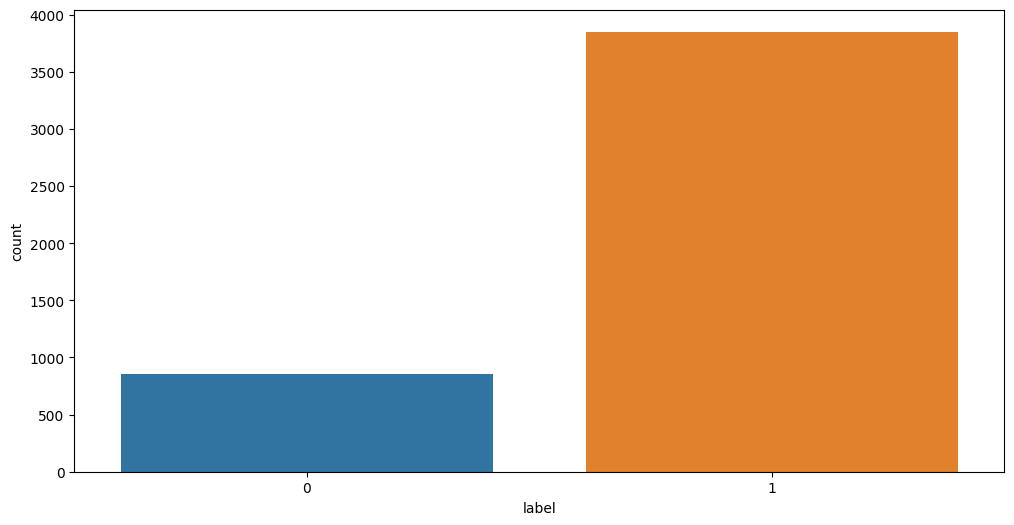

In [ ]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'label', data = df)

Terdapat 851 narasi yang diklasifikasikan bukan hoax dan 3850 narasi yang diklasifikasikan hoax. Terlihat bahwa ada ketimpangan pada jumlah data di masing-masing kelas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4701 non-null   int64 
 1   label             4701 non-null   int64 
 2   tanggal           4701 non-null   object
 3   judul             4701 non-null   object
 4   narasi            4701 non-null   object
 5   nama file gambar  4701 non-null   object
dtypes: int64(2), object(4)
memory usage: 220.5+ KB


In [ ]:
# mengecek missing value
df.isna().sum()

ID                  0
label               0
tanggal             0
judul               0
narasi              0
nama file gambar    0
dtype: int64

Tidak terdapat missing value.

## Deep Cleansing ##

In [ ]:
# load kamus
!gdown 186jhJoEtrDPWR17qA7oK5NpH9hum_K-M
!gdown 18qi4oWwon3Uod5egTsFt1H0Mbxinu0e5

Downloading...
From: https://drive.google.com/uc?id=186jhJoEtrDPWR17qA7oK5NpH9hum_K-M
To: /content/new_kamusalay.csv
100% 286k/286k [00:00<00:00, 3.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=18qi4oWwon3Uod5egTsFt1H0Mbxinu0e5
To: /content/utf8_char.csv
100% 72.0k/72.0k [00:00<00:00, 3.33MB/s]


In [ ]:
#remove unichar like emoji in utf-8
unichar = pd.read_csv("utf8_char.csv", sep='\t', header = None)
unichar_values = unichar[2].values
def remove_unichar_emoji(text):
    for i in unichar_values:
        text = text.replace(str(i), " ")
    return text

#Clean emojis from text
def strip_emoji(text):
    try:
        text = text.encode('latin1').decode('unicode-escape').encode('latin1').decode('utf8')
    except:
        pass
    #return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji
    return emoji.replace_emoji(text, replace=' ')

# remove semua karakter terkait html: unescape html eg. &nbsp; &amp; | link/url | tag html
import html
def remove_html(text):
    text = html.unescape(text)
    tag_pattern = re.compile(r'<.*?>')
    text = tag_pattern.sub(r'',text)
    regex_str = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    url_pattern = re.compile(regex_str)
    text = url_pattern.sub(r'', text)
    return text


# Fungsi untuk replace Accented Characters (Non-ASCII) dengan yg equivalen
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.lower()
    text = re.sub(r'(\w)(\1{2,})', r"\1", text) # will replace repeated char
    text = text.replace('\\r', ' ').replace('\\n', ' ') #remove \n and \r
    text = re.sub(r"\S*@\S*\s?", " ", text) #remove email
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r' ', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = text.translate(text.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = ' '.join(word for word in text.split() if not word.isnumeric()) #remove word only number
    text = re.sub(r'\b\w\b', "", text) #remove one letter only
    text = re.sub("(username|user|url|rt)\s|\s(user|url|rt)","",text)
    text = ' '.join(word for word in text.split() if len(word) < 21) # remove words longer than 21 characters
    text = ' '.join(word for word in text.split() if len(word) > 1) # remove words contain single letter only
    return text

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

kamus_alay1 = pd.read_csv('new_kamusalay.csv', encoding='CP1252', dtype = str, names=['alay', 'formal'])
kamus_alay1 = kamus_alay1.drop_duplicates(subset=['alay'], keep='first')
kamus_alay1 = kamus_alay1.set_index('alay')

def clean_alay(text):
    text_split = text.split(' ') #normalisasi
    for i in range(len(text_split)):
        if text_split[i] in kamus_alay1.index:
            text_split[i] = kamus_alay1.loc[text_split[i]]['formal']
    result = ' '.join(map(str, text_split))
    ######hilangkan lagi angka yg muncul
    result = ' '.join(word for word in result.split() if not word.isnumeric())
    return result

#Aplikasikan seluruh functions sesuai urutan
def clean_normalize(text):
    text = remove_unichar_emoji(text)
    text = strip_emoji(text)
    text = remove_html(text)
    text = remove_accented_chars(text)
    text = strip_all_entities(text)
    text = remove_mult_spaces(text)
    text = clean_alay(text)
    return text

In [ ]:
# melakukan pembersihan data
def clean_text(text):   # fungsi membersihkan teks
    text = unescape(text) # decoding/mengubah kode simbol menjadi simbol
    text = unidecode(text)  # encoding/mengubah simbol menjadi kata

    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    tagS = re.findall(getHashtags, text)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tag))
        text = text.replace('#'+tag,proper_words) #mengganti hashtag jadi kata dasarnya
    #text = str(text).lower()   # menjadikan teks huruf nonkapital
    return text

##Lakukan Pembersihan Pada Kolom 'Narasi'##

Kami memilih kolom 'narasi' untuk dibersihkan dan dianalisis lebih lanjut karena mencakup informasi mengenai berita atau topik yang dibicarakan dengan lebih detail. Menurut kami, kolom 'judul' juga dapat menggambarkan apakah informasi tersebut berupa hoax atau bukan, tapi 'narasi' akan lebih menggambarkan. Kolom 'narasi' juga kami anggap lebih merepresentasikan isi daripada hanya 'judul' yang terkadang dapat *misleading*.

In [ ]:
texts_new = df['narasi'].values

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(clean_text(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_unichar_emoji(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(strip_emoji(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_html(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_accented_chars(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(strip_all_entities(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(remove_mult_spaces(t))
texts_new = text_temporary

In [ ]:
text_temporary = []
for t in texts_new:
    text_temporary.append(clean_alay(t))
texts_new = text_temporary

##Cek Data Hasil Pembersihan##

In [ ]:
print('\nTeks ke DataFrame:')
# import texts new to dataframe
df['text_clean'] = texts_new
df.drop(columns=['ID', 'tanggal', 'nama file gambar'], inplace=True)
display(df.head(10), df.tail(10))


Teks ke DataFrame:


,label,judul,narasi,text_clean
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,caller to radio talk show recently shared that...
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,yang terhormat seluruh anggota grup sesuai ins...
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,jokowi adalah presiden terbaik dalam sejarah b...
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",maaf mas mas dan mbak mbak ini bukan politik t...
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,kadrun kalau lihat foto ini panas dingin
5,1,event promo smartphone JNE 2020 spesial di bul...,"selamat siang teman teman fb ku semuanya🤩,cuma...",selamat siang teman teman facebook ku semuanya...
6,1,MEREKA SUDAH MEMPERSIAPKAN DIRI DENGAN BAIK UN...,LIHATLAH MEREKA SUDAH MEMPERSIAPKAN DIRI DENGA...,lihatlah mereka sudah mempersiapkan diri denga...
7,1,Foto Presiden Italia menangis karena tak cukup...,Italia punya fasilitas perawatan kesehatan ter...,italia punya fasilitas perawatan kesehatan ter...
8,1,"Kapolres Timor Tengah Utara , Nusa Tenggara Ti...",Polisi goblok. Bukanya cpet” d tolongin malah ...,polisi goblok bukanya cepat tolongin malah lia...
9,1,Video Polisi china telah menganiaya wanita uig...,Polisi china telah menganiaya wanita uighur le...,polisi cina telah menganiaya wanita uighur leh...


,label,judul,narasi,text_clean
4691,1,"Kartu Pra Kerja Sudah Jadi, Menganggur Digaji",Asyik…kartu nya sudah jadi. Mendingan nganggur...,asyik kartu nya sudah jadi lebih baik mengangg...
4692,0,: Petugas Pintu Tol Bekasi Tolak Transaksi Uan...,Petugas Pintu Tol Bekasi Tolak Transaksi Uang ...,petugas pintu tol bekasi tolak transaksi uang ...
4693,1,Baznas Pasang Spanduk Menolak Tempat Perayaan ...,MASYARAKAT PANGANDARAAN MENOLAK KEGIATAN PERAY...,masyarakat pangandaraan menolak kegiatan peray...
4694,0,JJ Rizal Bantah Menjadi Tim Pertimbangan Monas,JJ Rizal membantah namanya masuk ke dalam Tim ...,jj rizal membantah namanya masuk ke dalam tim ...
4695,1,"Tulisan Partai Komunis Indonesia, Gambar Senap...",Jangan beranggapan Indonesia sejak d pimpin Jo...,jangan beranggapan indonesia sejak pimpin joko...
4696,0,Banser-PDIP Berdamai,Ratusan massa dari Barisan Serba Guna (Banser)...,ratusan massa dari barisan serba guna barisan ...
4697,1,ERDOGAN TAK MAU DUDUK DI KURSI TAMU YANG LEBIH...,ERDOGAN DATANG KE VATIKAN MENJUMPAI BABA (POP)...,erdogan datang ke vatikan menjumpai baba pop v...
4698,1,"Imigran China Sengaja Membawa Virus, Tujuannya...",IMIGRAN CN SENGAJA MEMBAWA VIRUS DAN MEREKA TE...,imigran cn sengaja membawa virus dan mereka te...
4699,1,BUKTI KECURANGAN JOKOWI BAGI SEMBAKO,Beredar dimana mana jadi VIRAL video ini\nApa ...,beredar dimana mana jadi viral video ini apa t...
4700,1,Anak Kecil Bersembunyi di Kolong Meja Saat Ber...,Naluri Anak Kecil Itu Tajam Boooss……..\n Saat ...,naluri anak kecil itu tajam bos saat didatangi...


In [ ]:
# cek data duplikat
print('shape:', df.shape)

# berapa banyak duplikat?
print('duplicate:', df['text_clean'].duplicated().sum())

# lihat baris-baris yang duplikat
df[df['text_clean'].duplicated()]

shape: (4701, 4)
duplicate: 39


,label,judul,narasi,text_clean
427,1,Antena 5G di dalam masker Anda,5G antenna inside of your masks,5g antenna inside of your masks
497,1,Foto All Jakarta Water Park,PERKENALKAN: ALL JAKARTA WATER PARK,perkenalkan all jakarta water park
687,1,Dibuang Sajaa,Cek tangkapan layar.,cek tangkapan layar
812,0,Jokowi Lebih Memilih Helikopter Buatan Luar Ne...,"INSTING MAKELAR\n \n AKU Awalnya kaget, membac...",insting makelar aku awalnya kaget membaca beri...
892,1,Corona is a hoax,CORONA IS A HOAX,corona is hoaks
1344,1,Foto Sekarang malesiya sapu habis penduduk asi...,Perhatian perhatian Sekarang malesiya makin da...,perhatian perhatian sekarang malesiya makin da...
1632,1,Data di Mabes TNI berdasarkan Formulir C1,Cek tangkapan layar.,cek tangkapan layar
1776,1,Foto Suntingan Jokowi,Cek tangkapan layar.,cek tangkapan layar
1777,1,Terdapat obat bius di daun teh Tiek Kwan Im,Cek tangkapan layar,cek tangkapan layar
1807,1,Sri Sultan Hamengku Buwono X Katakan Cina dan ...,"SRI SULTAN HAMENGKUBUWONO : MAAF BUKAN SARA, T...",sri sultan hamengkubuwono maaf bukan sara tapi...


In [ ]:
# drop data duplikat
df.drop_duplicates(['text_clean'], keep='first', inplace=True)
df = df.reset_index(drop=True)
print('new shape:', df.shape)

new shape: (4662, 4)


In [ ]:
# cek apakah ada missing value setelah dilakukan pembersihan
df.isna().sum()

label         0
judul         0
narasi        0
text_clean    0
dtype: int64

In [ ]:
# cek apakah ada yang hanya berisi spasi
df[df['text_clean'] == '']

,label,judul,narasi,text_clean
3721,1,Situs OPERAIND,#saveILC,


In [ ]:
# cek panjang kata setelah dilakukan pembersihan
df['length'] = df['text_clean'].str.split().map(lambda x: len(x))
df

,label,judul,narasi,text_clean,length
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,caller to radio talk show recently shared that...,80
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,yang terhormat seluruh anggota grup sesuai ins...,19
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,jokowi adalah presiden terbaik dalam sejarah b...,13
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",maaf mas mas dan mbak mbak ini bukan politik t...,124
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,kadrun kalau lihat foto ini panas dingin,7
...,...,...,...,...,...
4657,0,Banser-PDIP Berdamai,Ratusan massa dari Barisan Serba Guna (Banser)...,ratusan massa dari barisan serba guna barisan ...,27
4658,1,ERDOGAN TAK MAU DUDUK DI KURSI TAMU YANG LEBIH...,ERDOGAN DATANG KE VATIKAN MENJUMPAI BABA (POP)...,erdogan datang ke vatikan menjumpai baba pop v...,73
4659,1,"Imigran China Sengaja Membawa Virus, Tujuannya...",IMIGRAN CN SENGAJA MEMBAWA VIRUS DAN MEREKA TE...,imigran cn sengaja membawa virus dan mereka te...,30
4660,1,BUKTI KECURANGAN JOKOWI BAGI SEMBAKO,Beredar dimana mana jadi VIRAL video ini\nApa ...,beredar dimana mana jadi viral video ini apa t...,23


In [ ]:
#mengambil data yang lebih dari satu kata
df = df[df['length'] > 1]

# reset index
df = df.reset_index(drop=True)
df

,label,judul,narasi,text_clean,length,text_clean_viz
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,caller to radio talk show recently shared that...,80,caller radio talk show recently shared that hi...
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,yang terhormat seluruh anggota grup sesuai ins...,19,terhormat anggota grup instruksi gubernur jawa...
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,jokowi adalah presiden terbaik dalam sejarah b...,13,jokowi presiden terbaik sejarah bangsa indones...
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",maaf mas mas dan mbak mbak ini bukan politik t...,124,maaf politik kenyataan jokowi berhasil memulan...
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,kadrun kalau lihat foto ini panas dingin,7,kadrun lihat foto panas dingin
...,...,...,...,...,...,...
4651,0,Banser-PDIP Berdamai,Ratusan massa dari Barisan Serba Guna (Banser)...,ratusan massa dari barisan serba guna barisan ...,27,ratusan massa barisan serba barisan serba kade...
4652,1,ERDOGAN TAK MAU DUDUK DI KURSI TAMU YANG LEBIH...,ERDOGAN DATANG KE VATIKAN MENJUMPAI BABA (POP)...,erdogan datang ke vatikan menjumpai baba pop v...,73,erdogan vatikan menjumpai baba pop vatikan kur...
4653,1,"Imigran China Sengaja Membawa Virus, Tujuannya...",IMIGRAN CN SENGAJA MEMBAWA VIRUS DAN MEREKA TE...,imigran cn sengaja membawa virus dan mereka te...,30,imigran cn sengaja virus menyuntikan anti bodi...
4654,1,BUKTI KECURANGAN JOKOWI BAGI SEMBAKO,Beredar dimana mana jadi VIRAL video ini\nApa ...,beredar dimana mana jadi viral video ini apa t...,23,beredar viral video tindakan komisi pemelihan ...


In [ ]:
df['label'].value_counts()

1    3813
0     843
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

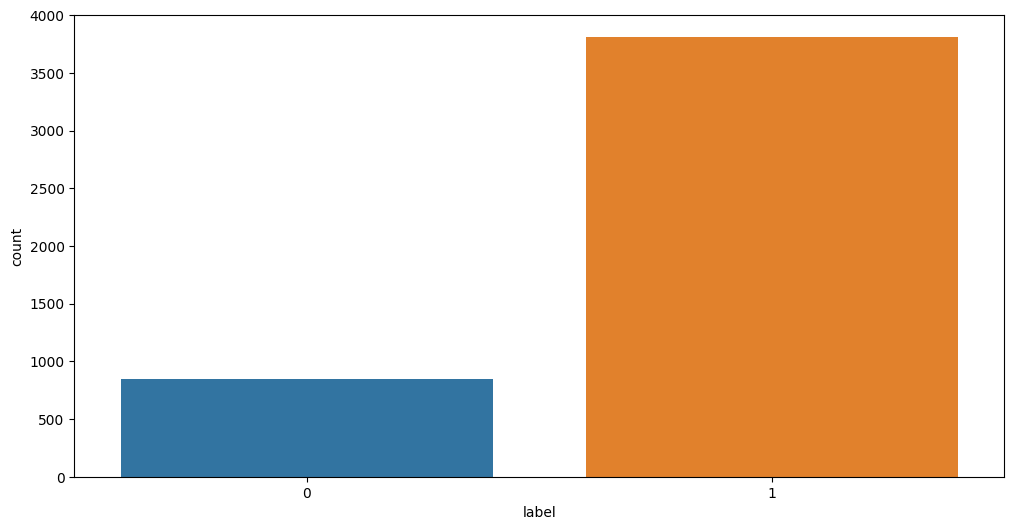

In [ ]:
plt.figure(figsize = (12, 6))
sns.countplot(x = 'label', data = df)

In [ ]:
#simpan ke file untuk backup
df.to_csv('/content/data_clean.csv', encoding = 'utf-8', index = False)

## Feature Engineering

In [ ]:
# clean dataset, download ulang saja
!gdown 14nnP63Ca6n_j5HDtZjx6dOLlCcKUP5cm

file1 = '/content/data_clean.csv'
df = pd.read_csv(file1)


Downloading...
From: https://drive.google.com/uc?id=14nnP63Ca6n_j5HDtZjx6dOLlCcKUP5cm
To: /content/data_clean.csv
100% 1.99M/1.99M [00:00<00:00, 13.9MB/s]


In [ ]:
df

,label,judul,narasi,text_clean,length
0,1,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,caller to radio talk show recently shared that...,80
1,1,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,yang terhormat seluruh anggota grup sesuai ins...,19
2,1,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,jokowi adalah presiden terbaik dalam sejarah b...,13
3,1,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",maaf mas mas dan mbak mbak ini bukan politik t...,124
4,1,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,kadrun kalau lihat foto ini panas dingin,7
...,...,...,...,...,...
4651,0,Banser-PDIP Berdamai,Ratusan massa dari Barisan Serba Guna (Banser)...,ratusan massa dari barisan serba guna barisan ...,27
4652,1,ERDOGAN TAK MAU DUDUK DI KURSI TAMU YANG LEBIH...,ERDOGAN DATANG KE VATIKAN MENJUMPAI BABA (POP)...,erdogan datang ke vatikan menjumpai baba pop v...,73
4653,1,"Imigran China Sengaja Membawa Virus, Tujuannya...",IMIGRAN CN SENGAJA MEMBAWA VIRUS DAN MEREKA TE...,imigran cn sengaja membawa virus dan mereka te...,30
4654,1,BUKTI KECURANGAN JOKOWI BAGI SEMBAKO,Beredar dimana mana jadi VIRAL video ini\nApa ...,beredar dimana mana jadi viral video ini apa t...,23


In [ ]:
#melakukan ekstraksi fitur menggunakan tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
X = vectorizer.fit_transform(df['text_clean'])
y=df['label']

## Splitting Data: Train and Test

In [ ]:
#melakukan pembagian data training dan data testing yang mana data training 80% dan data testing 20%
X=X.toarray()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=109)
print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

Train:  (3724, 17197) (3724,) Test:  ((932, 17197), (932,))


## Model Selection

SVM

In [ ]:
#pembuatan model menggunakan metode SVM
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
print("Confusion Matrix SVM")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
from sklearn.metrics import accuracy_score
acu_svm=accuracy_score(y_test,y_pred)
print('AKURASI SVM: %.3f' % acu_svm)
f1_svm = f1_score(y_test, y_pred)
print('F1 SCORE SVM: %.3f' % f1_svm)

Confusion Matrix SVM
[[ 37 130]
 [ 30 735]]
              precision    recall  f1-score   support

           0       0.55      0.22      0.32       167
           1       0.85      0.96      0.90       765

    accuracy                           0.83       932
   macro avg       0.70      0.59      0.61       932
weighted avg       0.80      0.83      0.80       932

AKURASI SVM: 0.828
F1 SCORE SVM: 0.902


DECISION TREE

In [ ]:
#pembuatan model dengan metode decision tree
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', random_state=1)

In [ ]:
dct.fit(X_train,y_train)
dct_tfidf = dct.predict_proba(X_test)
dct_tfidf

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [ ]:
# calculating f1 score
#threshold 1 if >= 0.5
dct_tfidf =dct_tfidf[:,1]>=0.5
dct_int_tfidf=dct_tfidf.astype(np.int)
dct_score_tfidf=f1_score(y_test,dct_tfidf)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix DECISION TREE")
print(confusion_matrix(y_test,dct_tfidf))
print(classification_report(y_test,dct_tfidf))
from sklearn.metrics import accuracy_score
acu_dct=accuracy_score(y_test,dct_tfidf)
print('AKURASI DECISION TREE: %.3f' % acu_dct)
print('F1 SCORE DECISION TREE: %.3f' % dct_score_tfidf)

Confusion Matrix DECISION TREE
[[ 50 117]
 [108 657]]
              precision    recall  f1-score   support

           0       0.32      0.30      0.31       167
           1       0.85      0.86      0.85       765

    accuracy                           0.76       932
   macro avg       0.58      0.58      0.58       932
weighted avg       0.75      0.76      0.76       932

AKURASI DECISION TREE: 0.759
F1 SCORE DECISION TREE: 0.854


NAIVE BAYES

In [ ]:
#pembuatan model dengan metode naive bayes
from sklearn.naive_bayes import GaussianNB
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Prediction
y_pred_NB = classifier_NB.predict(X_test)
y_pred_NB

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# calculating f1 score
nb_score=f1_score(y_test,y_pred_NB)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix NAIVE BAYES")
print(confusion_matrix(y_test,y_pred_NB))
print(classification_report(y_test,y_pred_NB))
from sklearn.metrics import accuracy_score
acu_NB=accuracy_score(y_test,y_pred_NB)
print('AKURASI NAIVE BAYES: %.3f' % acu_NB)
print('F1 SCORE NAIVE BAYES: %.3f' % nb_score)

Confusion Matrix NAIVE BAYES
[[ 43 124]
 [109 656]]
              precision    recall  f1-score   support

           0       0.28      0.26      0.27       167
           1       0.84      0.86      0.85       765

    accuracy                           0.75       932
   macro avg       0.56      0.56      0.56       932
weighted avg       0.74      0.75      0.75       932

AKURASI NAIVE BAYES: 0.750
F1 SCORE NAIVE BAYES: 0.849


XGBOOST

In [ ]:
#pembuatan model dengan XGBoost
from xgboost import XGBClassifier
model_xgb = XGBClassifier()

In [ ]:
model_xgb.fit(X_train, y_train)
xgb_tfidf=model_xgb.predict_proba(X_test)
xgb_tfidf

array([[0.22662717, 0.7733728 ],
       [0.08583522, 0.9141648 ],
       [0.2095946 , 0.7904054 ],
       ...,
       [0.08116692, 0.9188331 ],
       [0.42759728, 0.5724027 ],
       [0.02981877, 0.9701812 ]], dtype=float32)

In [ ]:
# calculating f1 score
#threshold 1 if >= 0.5
xgb_tfidf_pr =xgb_tfidf[:,1]>=0.5

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf_pr.astype(np.int)


xgb_score=f1_score(y_test,xgb_int_tfidf)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix XGBOOST")
print(confusion_matrix(y_test,xgb_int_tfidf))
print(classification_report(y_test,xgb_int_tfidf))
from sklearn.metrics import accuracy_score
acu_xgb=accuracy_score(y_test,xgb_int_tfidf)
print('AKURASI XGBOOST: %.3f' % acu_xgb)
print('F1 SCORE XGBOOST: %.3f' % xgb_score)

Confusion Matrix XGBOOST
[[ 30 137]
 [ 25 740]]
              precision    recall  f1-score   support

           0       0.55      0.18      0.27       167
           1       0.84      0.97      0.90       765

    accuracy                           0.83       932
   macro avg       0.69      0.57      0.59       932
weighted avg       0.79      0.83      0.79       932

AKURASI XGBOOST: 0.826
F1 SCORE XGBOOST: 0.901


LOGISTIC REGRESSION


In [ ]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression()
Log_Reg.fit(X_train,y_train)
prediction_logit = Log_Reg.predict_proba(X_test)
prediction_logit

array([[0.32023241, 0.67976759],
       [0.15900206, 0.84099794],
       [0.21455913, 0.78544087],
       ...,
       [0.10251972, 0.89748028],
       [0.30360116, 0.69639884],
       [0.15603891, 0.84396109]])

In [ ]:
# calculating f1 score
#threshold 1 if >= 0.5
prediction_int = prediction_logit[:,1]>=0.5

prediction_int = prediction_int.astype(np.int)
prediction_int

score_log = f1_score(y_test, prediction_int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix LOGIT")
print(confusion_matrix(y_test,prediction_int))
print(classification_report(y_test,prediction_int))
from sklearn.metrics import accuracy_score
acu_logit=accuracy_score(y_test,prediction_int)
print('AKURASI LOGIT: %.3f' % acu_logit)
print('F1 SCORE LOGIT: %.3f' % score_log)

Confusion Matrix LOGIT
[[ 12 155]
 [  2 763]]
              precision    recall  f1-score   support

           0       0.86      0.07      0.13       167
           1       0.83      1.00      0.91       765

    accuracy                           0.83       932
   macro avg       0.84      0.53      0.52       932
weighted avg       0.84      0.83      0.77       932

AKURASI LOGIT: 0.832
F1 SCORE LOGIT: 0.907


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
#calculating f1 score
prediction_rf = rf.predict_proba(X_test)
rf_tfidf = prediction_rf[:,1]>=0.3

# converting the results to integer type
rf_int_tfidf=rf_tfidf.astype(np.int)

# calculating f1 score
rf_score_tfidf=f1_score(y_test,rf_int_tfidf)

In [ ]:
print("Confusion Matrix RANDOM FOREST")
print(confusion_matrix(y_test,rf_int_tfidf))
print(classification_report(y_test,rf_int_tfidf))
acu_rf=accuracy_score(y_test,rf_int_tfidf)
print('AKURASI RANDOM FOREST: %.3f' % acu_rf)
print('F1 SCORE RANDOM FOREST: %.3f' % rf_score_tfidf)

Confusion Matrix RANDOM FOREST
[[  1 166]
 [  1 764]]
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       167
           1       0.82      1.00      0.90       765

    accuracy                           0.82       932
   macro avg       0.66      0.50      0.46       932
weighted avg       0.76      0.82      0.74       932

AKURASI RANDOM FOREST: 0.821
F1 SCORE RANDOM FOREST: 0.901


#Pemilihan Model Terbaik#

In [ ]:
#membandingkan f1 score seluruh model

Algo = ['SVM(TF-IDF)','LogisticRegression(TF-IDF)','XGBoost(TF-IDF)','DecisionTree(TF-IDF)',"NaiveBayes(TF-IDF)","RandomForest(TF-IDF)"]
accu = [acu_svm, acu_logit, acu_xgb, acu_dct, acu_NB, acu_rf]
score = [f1_svm,score_log,xgb_score,dct_score_tfidf,nb_score,rf_score_tfidf]

compare = pd.DataFrame({'Model':Algo,'Accuracy':accu,'F1_Score':score},index=[i for i in range(1,7)])
compare

,Model,Accuracy,F1_Score
1,SVM(TF-IDF),0.828326,0.901840
2,LogisticRegression(TF-IDF),0.831545,0.906714
3,XGBoost(TF-IDF),0.826180,0.901340
4,DecisionTree(TF-IDF),0.758584,0.853801
5,NaiveBayes(TF-IDF),0.750000,0.849191
6,RandomForest(TF-IDF),0.820815,0.901475


Terlihat bahwa model yang memiliki nilai F1 Score tertinggi adalah Regresi Logistik dengan fitur TF-IDF. Dibandingkan accuracy, F1 Score kami pilih sebagai penentu model terbaik karena F1 Score biasanya lebih berguna daripada akurasi, terutama jika data memiliki distribusi kelas yang tidak merata. Sebelumnya, telah terlihat bahwa data dengan label 'hoax' jauh lebih banyak dibandingkan yang 'nonhoax'.

## Hyperparameter Tuning with Cross Validation

In [ ]:
#akan dicari parameter optimal untuk model terbaik (regresi logistik)
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score
#https://drbeane.github.io/python_ml/pages/autosearch.html
def logreg_objective(trial):

    r = trial.suggest_float('l1_ratio', 0, 1, log=False)
    c = trial.suggest_float('C', 2, 8, log=False)

    clf =  LogisticRegression(max_iter=5000, l1_ratio=r, C=c)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=42)
logreg_study = optuna.create_study(direction='maximize',sampler=sampler)
logreg_study.optimize(logreg_objective, n_trials=10)

#get best parameters
print("\n\nBEST PARAMETERS : \n",logreg_study.best_params)

[I 2023-11-24 14:28:08,545] A new study created in memory with name: no-name-eae59f00-d573-41cc-955b-6560b6a95ef6
[I 2023-11-24 14:28:33,300] Trial 0 finished with value: 0.6937790614267187 and parameters: {'l1_ratio': 0.3745401188473625, 'C': 7.704285838459497}. Best is trial 0 with value: 0.6937790614267187.
[I 2023-11-24 14:28:58,256] Trial 1 finished with value: 0.6966495303520985 and parameters: {'l1_ratio': 0.7319939418114051, 'C': 5.59195090518222}. Best is trial 1 with value: 0.6966495303520985.
[I 2023-11-24 14:29:12,719] Trial 2 finished with value: 0.7028301398988506 and parameters: {'l1_ratio': 0.15601864044243652, 'C': 2.9359671220172157}. Best is trial 2 with value: 0.7028301398988506.
[I 2023-11-24 14:29:36,311] Trial 3 finished with value: 0.6943568188073336 and parameters: {'l1_ratio': 0.05808361216819946, 'C': 7.197056874649611}. Best is trial 2 with value: 0.7028301398988506.
[I 2023-11-24 14:30:00,542] Trial 4 finished with value: 0.6956077273109273 and parameters: 



BEST PARAMETERS : 
 {'l1_ratio': 0.15601864044243652, 'C': 2.9359671220172157}


In [ ]:
from sklearn.linear_model import LogisticRegression
#Log_Reg = LogisticRegression(max_iter=5000, l1_ratio= 0.03927887908102312, C=2.5073535573558265)
Log_Reg = LogisticRegression(max_iter=5000, l1_ratio= 0.15601864044243652, C=2.9359671220172157)
Log_Reg.fit(X_train,y_train)
prediction_logit = Log_Reg.predict_proba(X_test)
prediction_logit

array([[0.41181067, 0.58818933],
       [0.13619329, 0.86380671],
       [0.24304538, 0.75695462],
       ...,
       [0.06031614, 0.93968386],
       [0.37176043, 0.62823957],
       [0.14493988, 0.85506012]])

In [ ]:
# calculating f1 score
#threshold 1 if >= 0.5
prediction_int = prediction_logit[:,1]>=0.5

prediction_int = prediction_int.astype(np.int)
prediction_int

score_log = f1_score(y_test, prediction_int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix LOGIT")
print(confusion_matrix(y_test,prediction_int))
print(classification_report(y_test,prediction_int))
from sklearn.metrics import accuracy_score
acu_logit=accuracy_score(y_test,prediction_int)
print('AKURASI LOGIT: %.3f' % acu_logit)
print('F1 SCORE LOGIT: %.3f' % score_log)

Confusion Matrix LOGIT
[[ 26 141]
 [  5 760]]
              precision    recall  f1-score   support

           0       0.84      0.16      0.26       167
           1       0.84      0.99      0.91       765

    accuracy                           0.84       932
   macro avg       0.84      0.57      0.59       932
weighted avg       0.84      0.84      0.80       932

AKURASI LOGIT: 0.843
F1 SCORE LOGIT: 0.912


Dilihat dari F1-score setelah hyperparameter tuning optuna menggunakan cross validation, didapat kan F1-Score yang lebih baik sebesar 0.912. Maka, didapatkan model regresi logistik yang lebih optimal.

#Insight#

Stopwords pada data akan dihapus untuk visualisasi.

In [ ]:
import requests
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# CONSTRUCT STOPWORDS
rama_stopword = "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/stopword.txt"
yutomo_stopword = "https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt"
fpmipa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/fpmipa-stopwords.txt"
sastrawi_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/sastrawi-stopwords.txt"
aliakbar_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/aliakbars-bilp.txt"
pebahasa_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-list/pebbie-pebahasa.txt"
elang_stopword = "https://raw.githubusercontent.com/onlyphantom/elangdev/master/elang/word2vec/utils/stopwords-id.txt"
nltk_stopword = stopwords.words('indonesian')

# create path url for each stopword
path_stopwords = [rama_stopword, yutomo_stopword, fpmipa_stopword, sastrawi_stopword,
                  aliakbar_stopword, pebahasa_stopword, elang_stopword]

# combine stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

custom_st = '''
yg yang dgn ane smpai bgt gua gwa si tu ama utk udh btw
ntar lol ttg emg aj aja tll sy sih kalo nya trsa mnrt nih
ma dr ajaa tp akan bs bikin kta pas pdahl bnyak guys abis tnx
bang banget nang mas amat bangettt tjoy hemm haha sllu hrs lanjut
bgtu sbnrnya trjadi bgtu pdhl sm plg skrg
'''

# create dictionary with unique stopword
st_words = set(stopwords_l)
custom_stopword = set(custom_st.split())

# result stopwords
stop_words = st_words | custom_stopword
print(f'Stopwords: {list(stop_words)[:5]}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stopwords: ['jelaslah', 'seingat', 'keseluruhan', 'dapat', 'inilah']


In [ ]:
# remove stopwords untuk visualisasi
from nltk import word_tokenize, sent_tokenize

def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [ ]:
texts_new = df['text_clean'].values

text_temporary = []
for t in texts_new:
    text_temporary.append(remove_stopword(t))
texts_new = text_temporary

df['text_clean_viz'] = texts_new

In [ ]:
# Memisahkan DataFrame berdasarkan nilai kolom label (nonhoax dan hoax)
df_nonhoax = df[df['label'] == 0]
df_hoax = df[df['label'] == 1]

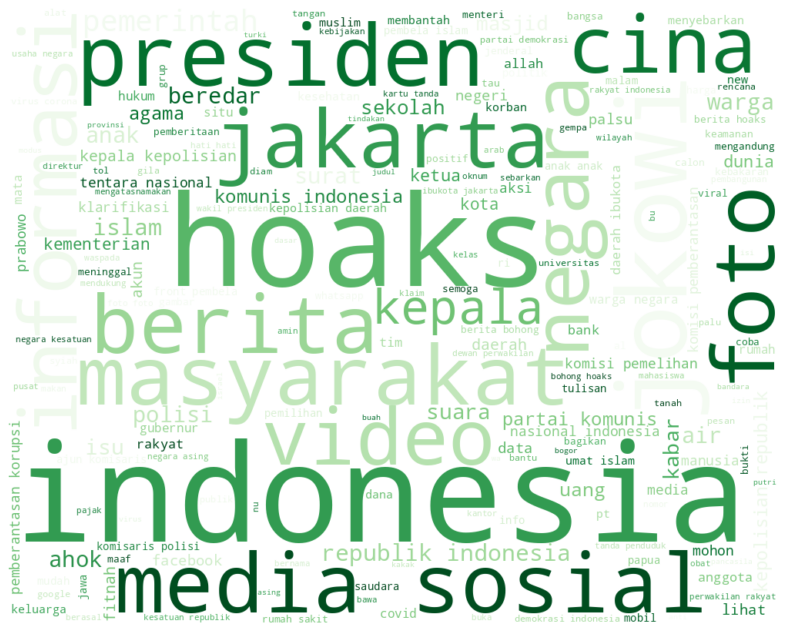

In [ ]:
# wordcloud nonhoax
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text = ' '.join(word for word in df_nonhoax['text_clean_viz'])
wordcloud = WordCloud(colormap='Greens', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(20,10), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

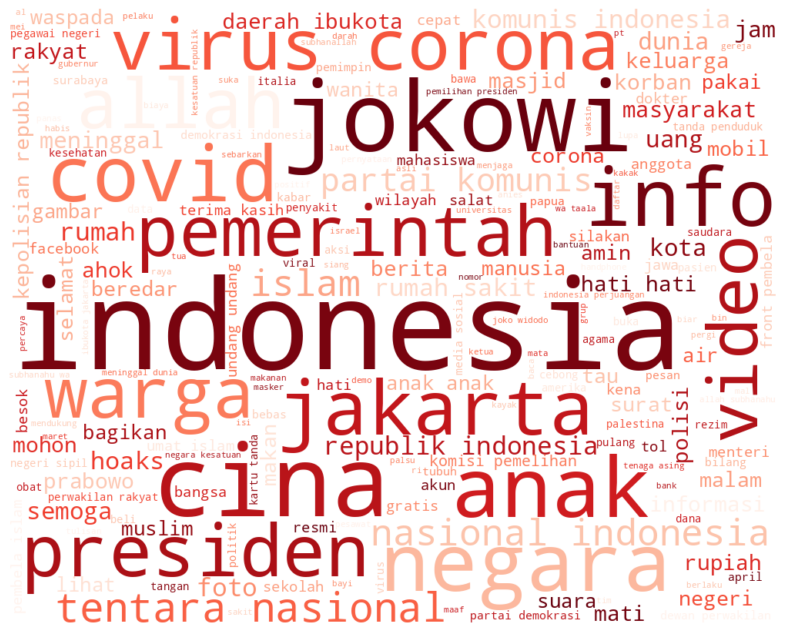

In [ ]:
# wordcloud hoax
all_text = ' '.join(word for word in df_hoax['text_clean_viz'])
wordcloud = WordCloud(colormap='Reds', width=1000, height=800, mode='RGBA', background_color='white').generate(all_text)

plt.figure(figsize=(20,10), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

##Wordlink dari kata-kata terbanyak pada narasi hoax##

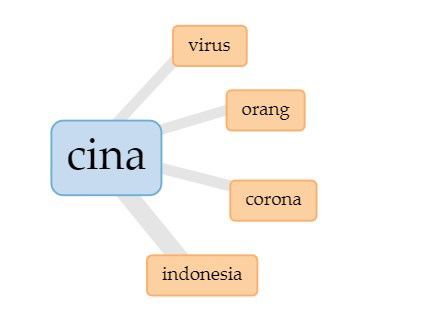

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Cina" paling banyak berkorelasi dengan kata seperti "virus", "orang", "corona", dan "Indonesia".

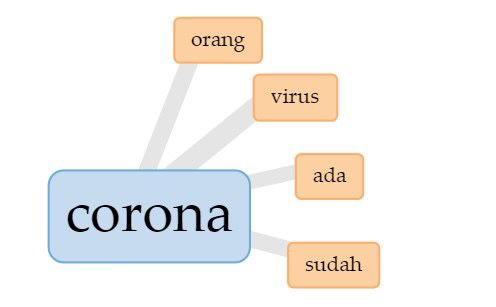

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Corona" paling banyak berkorelasi dengan kata seperti "orang", "virus", "ada", dan "sudah".

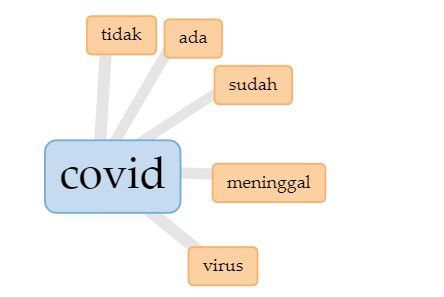

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Covid" paling banyak berkorelasi dengan kata seperti "tidak", "ada", "sudah", "meninggal", dan "virus".

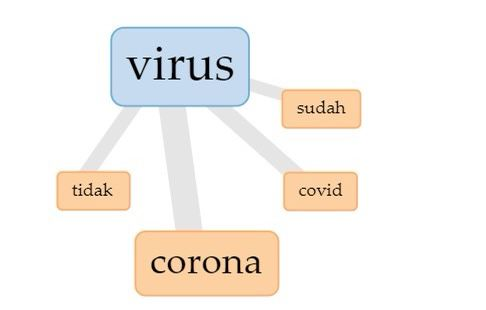

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Virus" paling banyak berkorelasi dengan kata seperti "tidak", "corona", "sudah", dan "covid". Dari keempat kata tersebut, "virus" memiliki korelasi terbanyak dengan "corona"

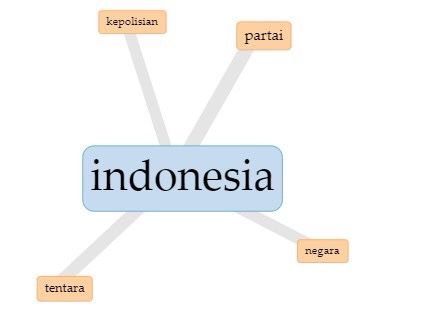

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Indonesia" paling banyak berkorelasi dengan kata seperti "kepolisian", "partai", "negara", dan "tentara".

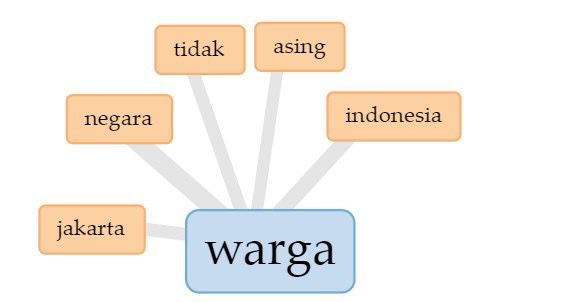

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Warga" paling banyak berkorelasi dengan kata seperti "Jakarta", "negara", "tidak", "asing", dan "Indonesia".

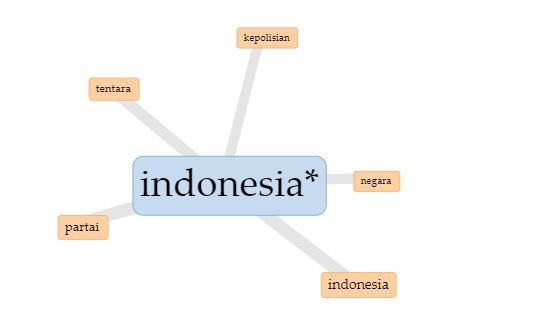

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Indonesia" atau kata-kata yang mirip dengan Indonesia paling banyak berkorelasi dengan kata seperti "kepolisian", "partai", "negara", dan "tentara".

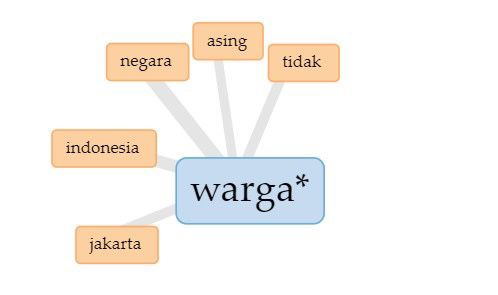

Berdasarkan hasil Wordlink di atas didapatkan bahwa kata "Warga" atau kata-kata yang mirip dengan warga seperti warga, kewarganegaraan, wargaa, dll paling banyak berkorelasi dengan kata seperti "kepolisian", "partai", "negara", dan "tentara".


**Insight yang Didapat**

Jika dilihat pada wordlink yang memiliki kata paling banyak terdapat di wordcloud, maka analisis teks ini mengenai isu virus Corona dan wabah Covid di Indonesia.

Hal yang harus dilakukan kominfo adalah:

1)  Verifikasi informasi
Verifikasi informasi meliputi asal dan penyebab penyebaran virus Corona, jumlah kematian pasien Covid dan penyebab spesifiknya, peraturan pemerintah mengenai peranan aparatur negara baik tentara maupun kepolisian dalam kasus covid di Indonesia, tren isu yang berkembang di partai politik, dampak covid bagi warga Jakarta. Dalam melakukan verifikasi, Mentri kominfo dapat bekerja sama dengan mentri kesehatan dan mentri ekonomi.

2) Klarifikasi
Perhatikan bahwa salah satu kata yang terbanyak pada data hoax adalah 'Cina' dengan word link-nya (kata-kata yang sering disebut bersamaan dengan kata 'Cina') adalah virus dan corona. Menurut kami, Kominfo perlu melakukan klarifikasi mengenai hoax-hoax yang beredar terkait kata 'Cina' secara masif. Misalnya dengan membuat *thread* di X sehingga masyarakat tertarik untuk membacanya, atau dengan menyiarkan berita di saat *prime time*. Alasannya adalah karena terdapat kemungkinan hoax-hoax tersebut bernada rasisme terhadap negara Tiongkok. Hal ini juga dapat menimbulkan perpecahan pada bangsa Indonesia apabila narasi hoax tersebut menyudutkan etnis Tionghoa di Indonesia.

3) Edukasi masyarakat
Mensosialisasikan dan mengedukasi masyarakat asal dan penyebab penyebaran virus Corona, jumlah kematian pasien Covid dan penyebab spesifiknya, peraturan pemerintah mengenai covid, dan protokol kesehatan dengan mengadaptasi tren video tiktok yang sedang ramai  karena melesatnya jumlah pengguna tiktok dan rata-rata screen time masyarakat meningkat selama masa pandemi.

4) Pemantauan
Selain itu, Kominfo juga perlu memperhatikan mengenai beberapa tokoh yang banyak disebutkan dalam berita-berita hoax tersebut. Hal ini dapat dilihat dari hasil wordcloud untuk berita hoax bahwa ada beberapa nama yang disebutkan seperti Jokowi dan Prabowo, dimana memungkinkan bahwa hal ini disalahgunakan oleh beberapa pihak untuk menjelekkan atau menimbulkan asumsi-asumsi kurang baik terhadap tokoh-tokoh tersebut dengan mengaitkannya dengan isu Covid ini sendiri.